## Fundamentals of Social Data Science
# Week 4 Day 1 Lab. Classification 

In this lab, you will be encouraged to explore your subreddits of choice using multinomial naive bayes and k-means classifications. Determine which one is more suitable using accuracy scores. Use both the TfIDFVectorizer and the CountVectorizer. 

Consider the use of stop words and lemmatisation. 

1. Plot the documents using t-SNE and then color the documents according the most accurate solution. 
2. For Naive Bayes report the 5 most informative terms per solution.  
* Would you be able to report the 5 most informative terms with k-means? This would be a bit far out for this lecture but if you are adventurous you can explore approaches like k-nearest neighbors using the centroids (as in report the 5 nearest neighbors to the centroid for each of the k solutions). 

There is only limited example code for this exercise. It is up to you to stitch together what you have learned as well as potentially draw upon external sources. On Wednesday we will provide an example solution.

Some guidance: 
1. Transform your headlines into a list similar to the walkthrough: [("headline (and maybe selftext)", "subreddit_label"), ("next headline", "next subreddit_label")]
 * Create one long list for all three subreddits to send to the Vectorizer. This is different to what I showed in Week 3 Day 3 where we had a separate vectorizer for each subreddit. To help you out I've started some code that creates a DataFrame for all the subs. 
2. Consider your tokenization. Will you use stop words or not? 
3. Consider plotting the classification on t-SNE to get some intuitions for how the solution maps out visually. 
4. Remember, are you classifying the documents using the terms? Or classifying the terms using the documents? Be careful with how you set this up. Notice that in the examples in the walkthrough we were classifying the documents using the terms. 
5. Consider the structure of this repository. Will you want to place some code for a plotting function in the `analysis.py`? What about creating a function under `text_processor.py` to transform the reddit data into the data structure needed. You can do everything in this Jupyter lab notebook but you should use this opportunity to think about how you might make use of this structure in order to help keep your code tidy. 


# Load packages and prepare data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from utils.analysis import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [21]:
# Get data from Reddit/ cache
scraper = RedditScraper(USER_AGENT)
subs_of_interest = ["AskMen", "AskWomen", "TooAfraidtoask"]

posts_list = []

for sub in subs_of_interest:    
    posts = scraper.get_subreddit_posts(sub, limit=10)
    df = create_posts_dataframe(posts)
    df['subreddit'] = sub
    posts_list.append(df)

posts_df = pd.concat(posts_list)
posts_df = posts_df.reset_index(drop=True)

In [3]:
# Import from Ryan's feather file
from pathlib import Path
import feather

# Load the feather file into a DataFrame
posts_df = feather.read_dataframe(Path.cwd() / "data" / "posts_df.feather")


In [4]:
# Transform the data into headline + body text and label
posts_df['text'] = posts_df['title'] + ' ' + posts_df['selftext']

# convert text to string
posts_df['text'] = posts_df['text'].astype(str)

In [5]:
# Tokenize the data

posts_df['tokenised_text_both'] = posts_df['text'].map(lambda x: preprocess_text_hyphen(x, option_stopwords="True", option_lemmatise="True", shortword=2))
posts_df['tokenised_text_lemmatise'] = posts_df['text'].map(lambda x: preprocess_text_hyphen(x, option_stopwords="False", option_lemmatise="True", shortword=2))
#posts_df['tokenised_text_stopwords'] = posts_df['text'].map(lambda x: preprocess_text_hyphen(x, option_stopwords="True", option_lemmatise="False", shortword=2))
#posts_df['tokenised_text_nothing'] = posts_df['text'].map(lambda x: preprocess_text_hyphen(x, option_stopwords="False", option_lemmatise="False", shortword=2))

# Keeping hyphens so words such as ex-boyfriend or make-up are kept together. Also keeps words such as full-time or self-esteem together

In [6]:
# Turn columns into a list of lists
def column_to_list(df, column1, column2):
    """ 
    Convert two columns of a dataframe into a list of lists in order to use them in a text processing exercise where need label and text.
    """
    return df[[column1, column2]].values.tolist()

tokenised_text_both = column_to_list(posts_df, 'tokenised_text_both', 'subreddit')
tokenised_text_lemmatise = column_to_list(posts_df, 'tokenised_text_lemmatise', 'subreddit')
#tokenised_text_stopwords = column_to_list(posts_df, 'tokenised_text_stopwords', 'subreddit')
#tokenised_text_nothing = column_to_list(posts_df, 'tokenised_text_nothing', 'subreddit')


In [7]:
# Save each subreddit in df 
askwomen_df= posts_df[posts_df['subreddit'] == 'AskWomen']
askmen_df= posts_df[posts_df['subreddit'] == 'AskMen']
tooafraid_df= posts_df[posts_df['subreddit'] == 'TooAfraidtoask']

In [8]:
# This is the tokenisation used:
tokenised_list = tokenised_text_both

# Split the list into text and label
corpus_text = [doc[0] for doc in tokenised_list]
corpus_label = [doc[1] for doc in tokenised_list]

# Plot post similarities (t-SNE)

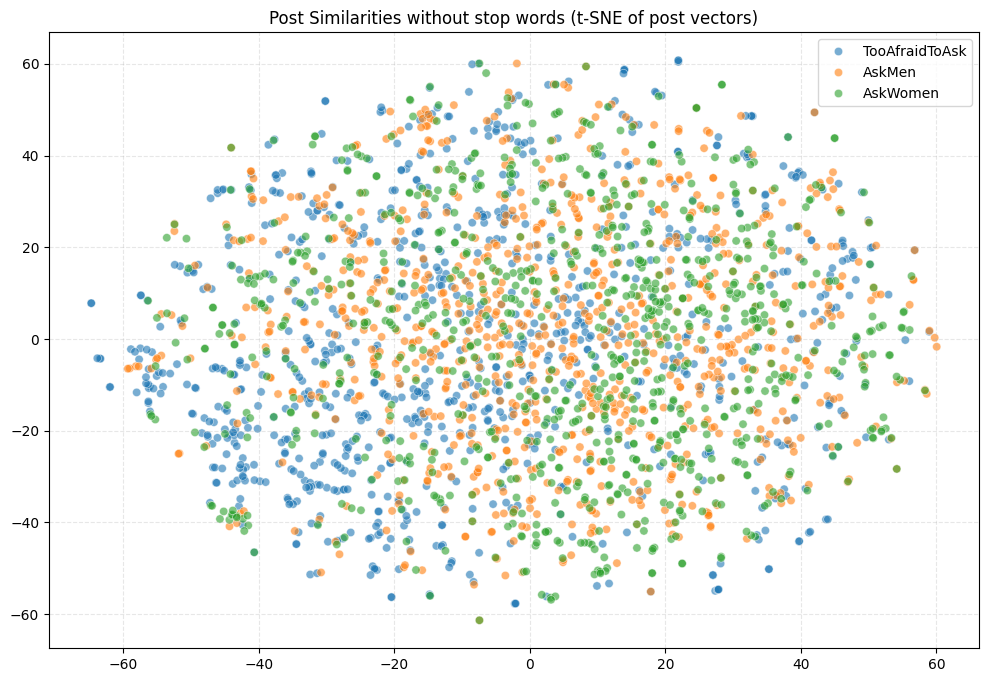

In [9]:
# Plot t-SNE similiarity of posts
vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+[-]?\w+\b") # allow for hyphens in words
tfidf_matrix = vectorizer.fit_transform(corpus_text)
feature_names = vectorizer.get_feature_names_out()

fig_doc, ax_doc = plot_similarities(tfidf_matrix, corpus_label, "Post Similarities without stop words (t-SNE of post vectors)",label_color=False)

The t-SNE plot shows a lot of overlap between all three Subreddits, indicating that similar topics may be discussed across Subreddits.
However, it seems like that there may be a topic or group of topics that are only discussed in the AskMen and TooAfraidToAsk since there is one cluster on the left side containing AskMen and TooAfraidToAsk posts but not contain many AskWomen posts, which is in line with our hypothesis that AskMen and TooAfraidToAsk are less distinct than AskWomen.

In [10]:
# This is the tokenisation used:
tokenised_list = tokenised_text_lemmatise

# Split the list into text and label
corpus_text = [doc[0] for doc in tokenised_list]
corpus_label = [doc[1] for doc in tokenised_list]

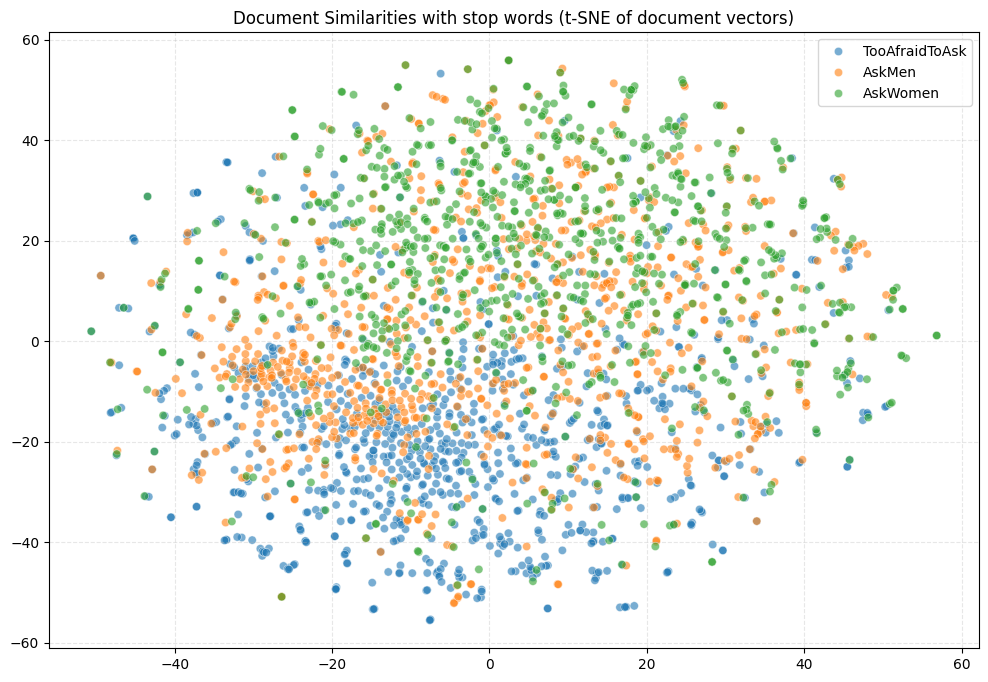

In [11]:
# Plot t-SNE similiarity of posts
vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+[-]?\w+\b") # allow for hyphens in words
tfidf_matrix = vectorizer.fit_transform(corpus_text)
feature_names = vectorizer.get_feature_names_out()

fig_doc, ax_doc = plot_similarities(tfidf_matrix, corpus_label, "Document Similarities with stop words (t-SNE of document vectors)",label_color=False)

# Better clustering when not removing stop words -> subreddits use different stop words
# AskMen and TooAfraidtoask more likely to use similar "and" (longer questions) while AskWomen more likely to use "you" (more personal questions)
# Look at length and whether include you

When not removing stop words the clustering seems to be more distinct and in line with our intial hypothesis since we can now differentiate between a AskWomen cluster and a mixed AskMen and TooAfraidToAsk cluster. This supports our hypothesis that stopwords may help to differentiate between subreddits due to using them in different ways. 

To further analysise whether different subreddits use different stopwords we carry out the Naive Bayes to find the most informative features for each subreddit. For AskMen and TooAfraidToAsk it is "and" while "and" is only the 10th most informative feature for AskWomen. We then carry out a Chi2 to examine whether the relative frequency of "and" is statistically different across the 3 subreddits and find that AskWomen uses "and" relatively less than AskMen and TooAfraidToAsk. Hence, this is against our hypothesis and may be driven by the fact that men maybe write more informally than women and thus use more "and".

# Chi2 and post-hoc chi2 for word frequency

In [12]:
from scipy.stats import chi2_contingency

# Quantify difference in the use of "and"

# Count the number of times "and" appears in the text and how many words there are
posts_df = extract_term("and", posts_df["tokenised_text_lemmatise"], posts_df, "")
posts_df["count_text"] = posts_df["tokenised_text_lemmatise"].str.split().str.len()
posts_df["fraction_and_post"] = (posts_df['count_and_'] / posts_df['count_text']) * 100

# Sum counts based on subreddit
subreddit_counts = posts_df.groupby('subreddit')[['count_and_', 'count_text']].sum()

# Calculate fraction of counts in each subreddit as percentage of overall word count
subreddit_counts['fraction_and'] = (subreddit_counts['count_and_'] / subreddit_counts['count_text']) * 100
subreddit_counts['fraction_and'] = subreddit_counts['fraction_and'].round(2)

subreddit_counts.rename(columns={'count_and_': 'Count of "and"', 'count_text': 'Word count', 'fraction_and': 'Fraction of "and" (%)'}, inplace=True)

print(subreddit_counts[['Count of "and"', 'Word count', 'Fraction of "and" (%)']])

# Create a contingency table
contingency_table = subreddit_counts[['Count of "and"', 'Word count']].values

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.2f}")

                Count of "and"  Word count  Fraction of "and" (%)
subreddit                                                        
AskMen                    1812       52412                   3.46
AskWomen                   623       23467                   2.65
TooAfraidToAsk            2616       73447                   3.56

Chi-square statistic: 43.36
P-value: 0.00


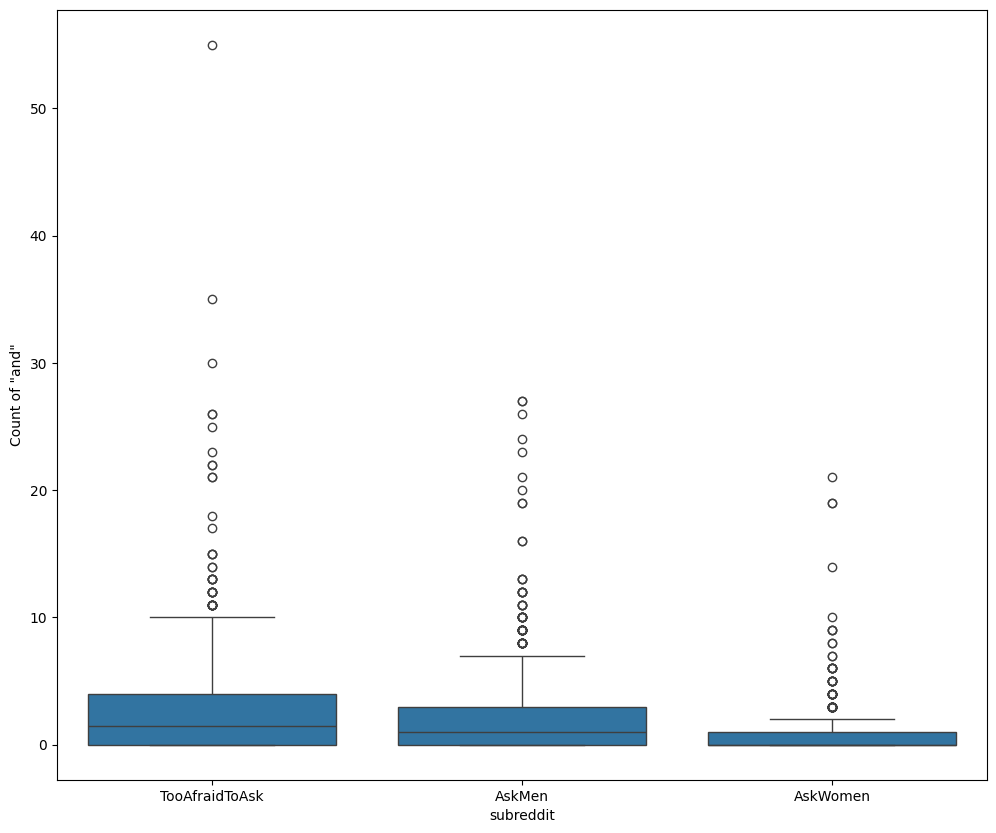

In [19]:
# Plot count of words and counts of why on bar plot

fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot count of "and" on primary y-axis
sns.boxplot(x='subreddit', y='count_and_', data=posts_df, ax=ax1)
ax1.set_ylabel('Count of "and"')
plt.show()



In [95]:
# Post-hoc pairwise comparisons chi2 test

# Subset the data for each pair of subreddits
askmen_vs_askwomen = subreddit_counts.loc[['AskMen', 'AskWomen']]
askmen_vs_tooafraid = subreddit_counts.loc[['AskMen', 'TooAfraidtoask']]
askwomen_vs_tooafraid = subreddit_counts.loc[['TooAfraidtoask', 'AskWomen']]

# Function to create a contingency table and perform chi2 test
def perform_chi_square(df):
    df=df.drop(columns=['fraction_and'])
    contingency_table = df.values
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Perform chi-square tests for each pair
chi2_am_aw, p_am_aw, _, _ = perform_chi_square(askmen_vs_askwomen)
chi2_am_ta, p_am_ta, _, _ = perform_chi_square(askmen_vs_tooafraid)
chi2_aw_ta, p_aw_ta, _, _ = perform_chi_square(askwomen_vs_tooafraid)

# Set the Bonferroni-corrected significance level because we are doing 3 post-hoc tests
alpha = 0.05
corrected_alpha = alpha / 3 
# Print the results
print(f"AskMen vs AskWomen: Chi-square = {chi2_am_aw:.2f}, p-value = {p_am_aw:.2f}")
print(f"AskMen vs TooAfraidToAsk: Chi-square = {chi2_am_ta:.2f}, p-value = {p_am_ta:.2f}")
print(f"AskWomen vs TooAfraidToAsk: Chi-square = {chi2_aw_ta:.2f}, p-value = {p_aw_ta:.2f}")

# Check if p-values are below the corrected alpha threshold
print(f"\nCorrected alpha threshold: {corrected_alpha:.2f}")
print(f"AskMen vs AskWomen statistically different? {p_am_aw < corrected_alpha}")
print(f"AskMen vs TooAfraidToAsk statistically different? {p_am_ta < corrected_alpha}")
print(f"AskWomen vs TooAfraidToAsk  statistically different? {p_aw_ta < corrected_alpha}")


AskMen vs AskWomen: Chi-square = 95.42, p-value = 0.00
AskMen vs TooAfraidToAsk: Chi-square = 0.82, p-value = 0.37
AskWomen vs TooAfraidToAsk: Chi-square = 107.37, p-value = 0.00

Corrected alpha threshold: 0.02
AskMen vs AskWomen statistically different? True
AskMen vs TooAfraidToAsk statistically different? False
AskWomen vs TooAfraidToAsk  statistically different? True


# Naive Bayes

In [25]:
# Naive Bayes Classifier
# With tf-idf score
def naive_bayes(minimum_occurrences_word: int, corpus_text: list, corpus_label: list, random: int, testsize: float, n=10, tfidf=True, report=True, tokenpattern=r"(?u)\b\w\w+\b"):
    """
    Function to perform Naive Bayes Classification on a given dataset and return the classification report.
    - Corpus_text is a list of strings
    - Corpus_label is a list of labels
    - Random is the random state for the train_test_split
    - Testsize is the size of the test set
    - Tfidf is a boolean to determine if tfidf should be used
    - Report is a boolean to determine if the classification report should be returned or the most informative features
    - N is the number of most informative features to return
    """
    if tfidf:
        vectorizer = TfidfVectorizer(min_df=minimum_occurrences_word, token_pattern=tokenpattern)
        tfidf_matrix = vectorizer.fit_transform(corpus_text)
    else:
        vectorizer = CountVectorizer(min_df=minimum_occurrences_word)
        tfidf_matrix = vectorizer.fit_transform(corpus_text)

    # Split data for NBC
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, corpus_label, test_size=testsize, random_state=random)

    # Naive Bayes Classification
    nbc = MultinomialNB()
    nbc.fit(X_train, y_train)
    nbc_pred = nbc.predict(X_test)
    
    if report:
        return classification_report(y_test, nbc_pred)
    
    else:
        top_features = most_informative_features(vectorizer, nbc, n)
        top_features_df = pd.DataFrame()
        for class_label, features in top_features.items(): 
            top_features_df[class_label] = [(feature, f'{np.exp(score):.4f}') for feature, score in features]

        return top_features_df

# Perform Naive Bayes Classification with CountVectorizer
report = naive_bayes(2, corpus_text, corpus_label, 42, 0.3, 10, tfidf=True, report=True, tokenpattern=r"(?u)\b\w+[-]?\w+\b")
print(f"Naive Bayes Classification Report with TfidfVectorizer: \n{report}")

features = naive_bayes(2, corpus_text, corpus_label, 42, 0.3, 10, tfidf=True, report=False,tokenpattern=r"(?u)\b\w+[-]?\w+\b")
print(f"Naive Bayes Most Informative Features with TfidfVectorizer: \n{features}")

Naive Bayes Classification Report with TfidfVectorizer: 
                precision    recall  f1-score   support

        AskMen       0.51      0.76      0.61       252
      AskWomen       0.83      0.50      0.62       286
TooAfraidToAsk       0.79      0.78      0.79       272

      accuracy                           0.67       810
     macro avg       0.71      0.68      0.67       810
  weighted avg       0.72      0.67      0.67       810

Naive Bayes Most Informative Features with TfidfVectorizer: 
           AskMen         AskWomen    TooAfraidToAsk
0   (you, 0.0072)    (you, 0.0104)     (the, 0.0068)
1   (the, 0.0070)   (what, 0.0070)     (and, 0.0066)
2   (and, 0.0056)   (your, 0.0056)    (that, 0.0040)
3  (what, 0.0054)    (the, 0.0049)    (have, 0.0039)
4  (that, 0.0042)  (woman, 0.0048)    (this, 0.0039)
5  (have, 0.0040)   (have, 0.0040)  (people, 0.0036)
6   (men, 0.0039)   (that, 0.0038)    (like, 0.0033)
7  (your, 0.0038)    (how, 0.0037)    (just, 0.0033)
8   (for, 

Summarise NBC results: 

The classifier doesn't seem to perform very well across all three subreddits as the f1 score is close to 0.5 (and thus close to random chance) for all of them. This is in line with t-SNE that showed a lot of overlap between the subreddits.

Interestingly, the classifier has a higher precision for AskWomen compared to AskMen and TooAfraidToAsk but a lower recall than AskMen and TooAfraidToAsk. This means that if the classifier classifies a post as AskWomen it is more likely correct that when it classifies the other subreddits. However, looking at recall while the classifier is very likely correct when classifying a post as from AskWomen, it misses a lot. Hence, the classifier classifies too many posts as AskMen and thus misses out on a lot of AskWomen and hence particularly struggles to distinguish between AskMen and AskWomen. This may be because the influential features suggest that AskMen and AskWomen both talk more about relationships than TooAfraidToAsk. While TooAfraidToAsk seem to concentrate more on a diverse area of questions since there are mainly verbs.


# K-means

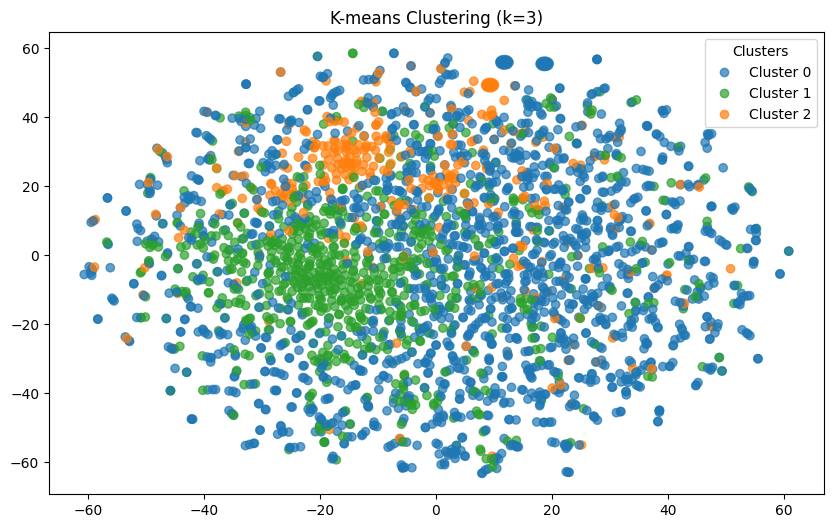


K-means Clustering Results:
                precision    recall  f1-score   support

        AskMen       0.45      0.53      0.48       964
      AskWomen       0.43      0.78      0.56       998
TooAfraidtoask       0.00      0.00      0.00       981

      accuracy                           0.44      2943
     macro avg       0.29      0.44      0.35      2943
  weighted avg       0.29      0.44      0.35      2943


 Cluster to Label Counts:
{np.int32(1): {'AskMen': 364, 'AskWomen': 71, 'TooAfraidtoask': 355}, np.int32(0): {'AskMen': 453, 'AskWomen': 780, 'TooAfraidtoask': 564}, np.int32(2): {'AskMen': 147, 'AskWomen': 147, 'TooAfraidtoask': 62}}

 Shilouette Score:
0.0030280125811313215


c:\Users\leins\Desktop\Master SDS\Michaelmas_Term\Fundamentals_of_Python\Week_3\oii-fsds-textanalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leins\Desktop\Master SDS\Michaelmas_Term\Fundamentals_of_Python\Week_3\oii-fsds-textanalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leins\Desktop\Master SDS\Michaelmas_Term\Fundamentals_of_Python\Week_3\oii-fsds-textanalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Pre

In [94]:
# K-means Classifier 
custom_cmap = ListedColormap(['#1f77b4', '#2ca02c', '#ff7f0e'])

def k_means(minimum_occurrences_word: int, corpus_text: list, corpus_label: int, clusters: int, tokenpattern=r"(?u)\b\w\w+\b"):
    
    """Function to perform K-means clustering on a given dataset and plot the results"""
    
    vectorizer = TfidfVectorizer(min_df=minimum_occurrences_word, token_pattern=tokenpattern)
    tfidf_matrix = vectorizer.fit_transform(corpus_text)
    feature_names = vectorizer.get_feature_names_out()

    # Create and fit the k-means model
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Reduce dimensionality for plotting
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(feature_names)/4), metric='cosine')
    tfidf_matrix_2d = tsne.fit_transform(tfidf_matrix.toarray())

    # Shilouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the data points, colored by their cluster assignments
    scatter = plt.scatter(tfidf_matrix_2d[:, 0], tfidf_matrix_2d[:, 1], c=cluster_labels, cmap=custom_cmap, alpha=0.7)
    
    # Plot the cluster centers
    # cluster_centers_2d = tsne.fit_transform(kmeans.cluster_centers_)
    # plt.scatter(cluster_centers_2d[:, 0], 
                # cluster_centers_2d[:, 1], 
                # c='red', 
                # marker='x', 
                # s=200, 
                # linewidth=3, 
                # label='Centroids')

    plt.title(f'K-means Clustering (k={clusters})')
    
    # Add a legend
    legend_labels = [f'Cluster {i}' for i in range(clusters)]
    legend_handles = scatter.legend_elements()[0]  # Get the handles for the legend
    plt.legend(legend_handles, legend_labels, title="Clusters", loc='upper right')

    plt.show()

     # Determine the majority label for each cluster
    cluster_label_counts = {}
    for cluster_label, true_label in zip(cluster_labels, corpus_label):
        if cluster_label not in cluster_label_counts:
            cluster_label_counts[cluster_label] = {}
        if true_label not in cluster_label_counts[cluster_label]:
            cluster_label_counts[cluster_label][true_label] = 0
        cluster_label_counts[cluster_label][true_label] += 1

    # Map clusters to majority labels
    cluster_to_label = {
      cluster: max(counts.items(), key=lambda x: x[1])[0]
        for cluster, counts in cluster_label_counts.items()
    }

    # Convert cluster numbers to predicted labels
    kmeans_pred = [cluster_to_label[label] for label in cluster_labels]
    
    return kmeans_pred, cluster_label_counts, cluster_to_label, silhouette_avg

kmeans_pred, cluster_label_counts,cluster_to_label, silhouette_avg = k_means(2, corpus_text, corpus_label, 3, tokenpattern=r"(?u)\b\w+[-]?\w+\b")

print("\nK-means Clustering Results:")
print(classification_report(corpus_label, kmeans_pred))
print("\n Cluster to Label Counts:")
print(cluster_label_counts)
print("\n Shilouette Score:")
print(silhouette_avg)

Summarise k-Means results:
k-means doesn't do a good job at classifying the subreddits especially because AskMen is the majority label for two clusters.
Cluster 0 seems to capture most of the AskWomen posts but because it is so spread out it captures also a lot of posts from other subreddits. This means while recall is high precision is low.
Cluster 1 seems to be good at differentiating between AskMen/ TooAfraidToAsk and AskWomen while cluster 2 seems to be good at differentiating between AskMen/ AskWomen and TooAfraidToAsk. 
This may suggest that for certain topics there is a bigger overlap between AskMen and AskWomen and for others there is a bigger overlap between AskMen and TooAfraidToAsk.
However, the overlap between AskMen and TooAfraidToAsk is bigger because there is 

Group Project Ideas
- See if subreddits are distinct if documents within subreddit similiar (t-SNE post similiarity)
- Make hypothesis about informative features in Naive Bayes (Naive bayes)
- If k-means properly classifies groups can be seen as more distinct (k-means)
- Look if word "woman" is associated with other words in different subreddits (t-SNE term similarity)

# Word associations (t-SNE for term similarity)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Associations with "woman" in TooAfraidToAsk (Closest 15 Words Highlighted)'}>)

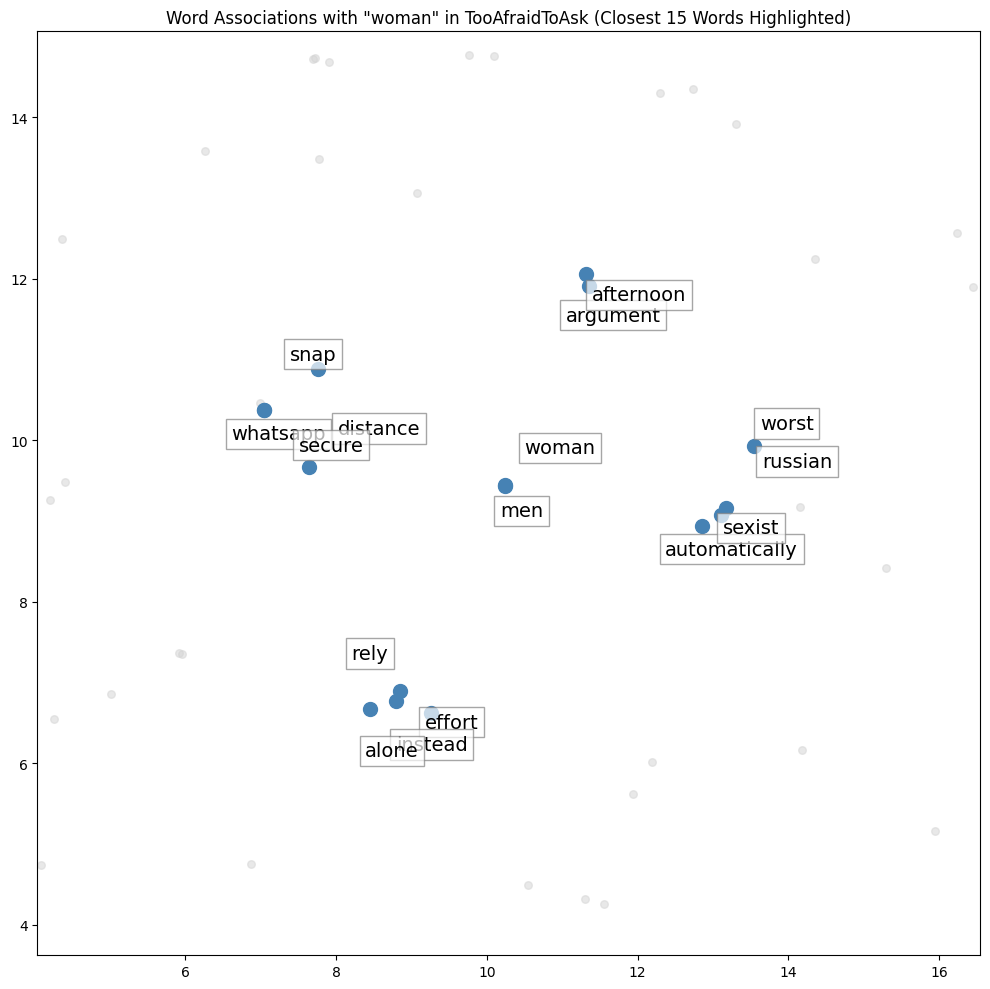

In [ ]:
# With what is the word "women" associated with in different subreddits?

askmen_text= askmen_df['tokenised_text_both'].tolist()

vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+[-]?\w+\b") # allow for hyphens in words
tfidf_matrix = vectorizer.fit_transform(askmen_text)
feature_names = vectorizer.get_feature_names_out()

plot_word_associations_tsne(tfidf_matrix, feature_names,target_word='woman', n_highlight=15, title="AskMen", zoom_factor=3, jitter_strength=0.75)

askwomen_text= askwomen_df['tokenised_text_both'].tolist()

vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+[-]?\w+\b") # allow for hyphens in words
tfidf_matrix = vectorizer.fit_transform(askwomen_text)
feature_names = vectorizer.get_feature_names_out()

plot_word_associations_tsne(tfidf_matrix, feature_names,target_word='woman', n_highlight=15, title="AskWomen", zoom_factor=3, jitter_strength=0.35)

tooafraid_text= tooafraid_df['tokenised_text_both'].tolist()

vectorizer = TfidfVectorizer(min_df=2, token_pattern=r"(?u)\b\w+[-]?\w+\b") # allow for hyphens in words
tfidf_matrix = vectorizer.fit_transform(tooafraid_text)
feature_names = vectorizer.get_feature_names_out()

plot_word_associations_tsne(tfidf_matrix, feature_names,target_word='woman', n_highlight=15, title="TooAfraidToAsk", zoom_factor=3, jitter_strength=0.6)